In [ ]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# 필요한 패키지와 모듈을 불러옴
import cv2
import numpy as np
import matplotlib.pyplot as plt

width: 960 pixels
height: 721 pixels
channels: 3


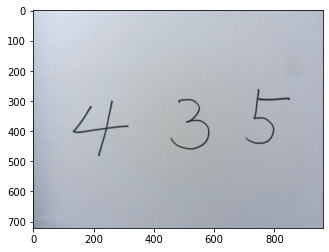

In [ ]:
# 숫자가 쓰여져 있는 이미지 파일을 읽어 옵니다.
frame = 'gdrive/My Drive/CV/Digits Classify/435.jpg'

img = cv2.imread(frame)
plt.imshow(img);
print("width: {} pixels".format(img.shape[1]))
print("height: {} pixels".format(img.shape[0]))
print("channels: {}".format(img.shape[2]))

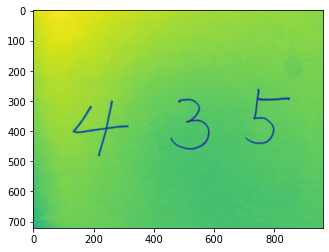

In [ ]:
# 이미지를 BGR to HSV(HSV filter 적용)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue, saturation, value = cv2.split(hsv)   # 색상(hue), 채도(saturation), 명도(value)
plt.imshow(value)                         # 명도 이미지를 보여준다.

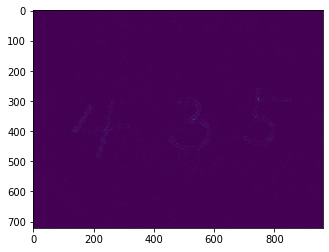

In [ ]:
# morphological operations 을 사용하기 위해 kernel 정의
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# topHat operations 을 적용한다.
topHat = cv2.morphologyEx(value, cv2.MORPH_TOPHAT, kernel)
plt.imshow(topHat)

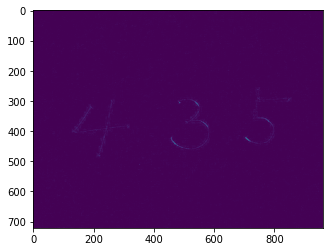

In [ ]:
# blackHat operations 을 적용한다.
blackHat = cv2.morphologyEx(value, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackHat)

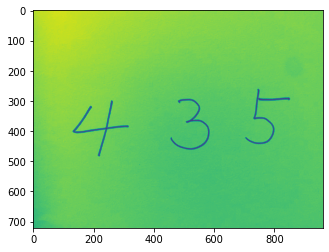

In [ ]:
# morphological operations 간에 add and subtract
add = cv2.add(value, topHat)
subtract = cv2.subtract(add, blackHat)
plt.imshow(subtract)

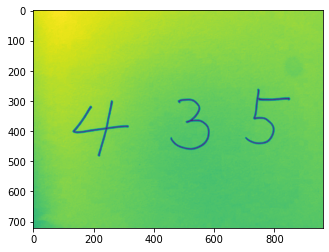

In [ ]:
# subtract 이미지에 gaussian blur를 적용한다.
blur = cv2.GaussianBlur(subtract, (5, 5), 0)
plt.imshow(blur)

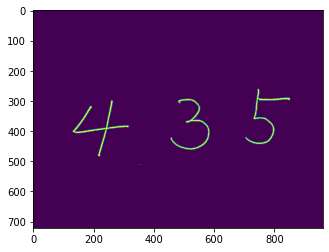

In [ ]:
# blur 이미지에 threshold를 적용한다.
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)
plt.imshow(thresh)

In [ ]:
# cv2.findCountours 함수가 OpenCV 버전이 업그레이드 됨에 따라 파라메터 개수에 변동이 있었음.
# OpenCV 버전4 이상은 파라메터 개수가 2개, OpenCV 버전4 미만은 파라메터 개수가 3개
cv2MajorVersion = cv2.__version__.split(".")[0]
print('openCV version : ', cv2MajorVersion)
# thresh 이미지에서 contour들을 찾아온다.
if int(cv2MajorVersion) >= 4:
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
else:
    imageContours, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

openCV version :  4


131 317 299 484
455 584 294 462
703 851 261 443


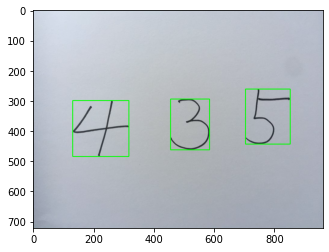

In [ ]:
img_digits = []          # digit 이미지가 저장되는 배열 정의 
margin = 10              # digit 이미지 저장 여유 마진

for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)     # contour 주변을 사각형으로 찾아옴
  # 찾아온 이미지가 너무 작다면 무시함
  if w * h < 100: continue
  # Y and X [y-margin:y+h+margin, x-margin:x+w+margin]
  # contour boxing 위치 좌표를 계산하여 thresh 이미지로부터 digit image 를 구해 img_digits 배열에 넣어준다.
  img_digits.append(thresh[y-margin:y+h+margin, x-margin:x+w+margin])
  # 원본 이미지에 contour boxing 영역을 사각형으로 표시해 준다.
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
  print(x,  x+w, y, y+h)
plt.imshow(img)

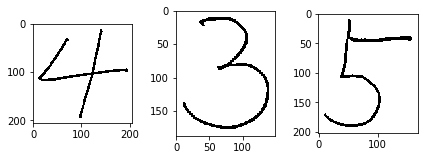

In [ ]:
# img_digits 배열에 어떠한 digit image 가 저장되어 있는지 확인해 본다. 
for i in range(0, len(img_digits)):
    plt.subplot(1, len(img_digits), i+1)
    plt.imshow(img_digits[i], cmap='Greys', interpolation='nearest')
plt.tight_layout()
plt.show() 

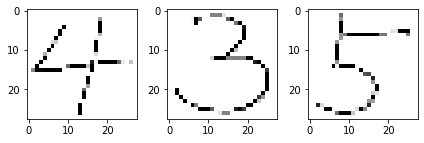

In [ ]:
# img_digits 배열의 크기가 서로 다른 이미지들을 모두 28X28 로 재조정해서 Display 합니다.

SZ = 28

for i in range(0, len(img_digits)):
    plt.subplot(1, len(img_digits), i+1)
    plt.imshow(cv2.resize(img_digits[i], (SZ, SZ)), cmap='Greys', interpolation='nearest')
plt.tight_layout()
plt.show() 

Load Deep Learning Model

In [ ]:
import tensorflow as tf

# 저장해 두었던 모델을 불러옵니다.
model = tf.keras.models.load_model('gdrive/My Drive/CV/Digits Classify/digits_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0

[-20.932016, -3.1033762, -3.2972586, -15.474698, 12.642788, -1.8608065, -8.511434, 1.3184569, -4.4360037, -3.0023787]
[-18.19208, -17.284874, -2.2905233, 28.6026, -24.54759, 6.4746094, -9.533062, -15.029928, -3.8925078, -8.916484]
[-13.403194, -11.50293, -14.183293, 2.6014524, -8.385264, 19.06439, -9.189472, -5.4377117, 0.8785815, 5.2884364]


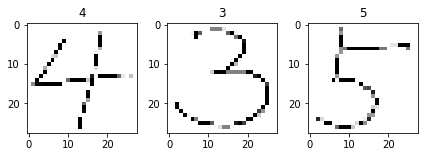

In [ ]:
# img_digits 배열 있는 이미지들을 우리가 만든 모델에 넣어 분류 예측해 봅니다. 

SZ = 28

for i in range(0, len(img_digits)):
    plt.subplot(1, len(img_digits), i+1)
    # img_digits 배열의 크기가 서로 다른 이미지들을 모두 28X28 로 재조정한다.
    num = cv2.resize(img_digits[i], (SZ,SZ))
    # 픽셀 값을 0~1 범위로 변환 
    num = num.astype('float32') / 255.
    # 이미지를 Display 합니다.
    plt.imshow(num, cmap='Greys', interpolation='nearest');
    # 이미지를 우리가 만든 모델을 통해 분류 예측해 봅니다.
    result = model.predict(np.array([num]))
    result_number = np.argmax(result)
    plt.title(result_number)
    performance = [val for val in result[0]]
    print(performance)
plt.tight_layout()
plt.show()